In [3]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Attention, Input
from tensorflow.python.ops.init_ops import he_normal
from keras.backend import concatenate
import keras.backend as K

In [4]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [5]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [6]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


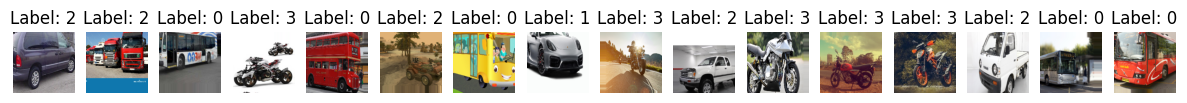

In [7]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [8]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = Attention()([x, x])
    x = x + att
    
    return x


In [9]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
      
    att = Attention()([x, x])
    x = x + att
    
    return x


In [10]:
def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    
    att = Attention()([x, x])
    x = x + att
    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage

combined_model = create_combined_model(input_shape)

In [11]:

def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)

def custom_accuracy(y_true, y_pred):
    # Assuming one-hot encoded vectors
    true_labels = tf.argmax(y_true, axis=-1)
    predicted_labels = tf.argmax(y_pred, axis=-1)

    # Check if the predicted labels match the true labels
    accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))
    
    return accuracy

In [12]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
from keras.optimizers import Adam
new_learning_rate = 0.001  # 设置你想要的学习率
custom_optimizer = Adam(lr=new_learning_rate)

# Compile the model
combined_model.compile(optimizer='Adam', 
              loss=custom_categorical_crossentropy, 
              metrics=[custom_accuracy]
              )

C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# Train the model
history = combined_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 29s 1s/step - loss: 3.3041 - custom_accuracy: 0.1840 - val_loss: 1.3945 - val_custom_accuracy: 0.2431
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 1.3830 - custom_accuracy: 0.2465 - val_loss: 1.3632 - val_custom_accuracy: 0.3212
Epoch 3/100
18/18 [==============================] - 21s 1s/step - loss: 1.3839 - custom_accuracy: 0.2604 - val_loss: 1.3754 - val_custom_accuracy: 0.2465
Epoch 4/100
18/18 [==============================] - 21s 1s/step - loss: 1.3780 - custom_accuracy: 0.3125 - val_loss: 1.3144 - val_custom_accuracy: 0.3802
Epoch 5/100
18/18 [==============================] - 21s 1s/step - loss: 1.3703 - custom_accuracy: 0.3125 - val_loss: 1.3555 - val_custom_accuracy: 0.2587
Epoch 6/100
18/18 [==============================] - 21s 1s/step - loss: 1.3507 - custom_accuracy: 0.3403 - val_loss: 1.3612 - val_custom_accuracy: 0.2587
Epoch 7/100
18/18 [==============================] - 21s 1s/step - los

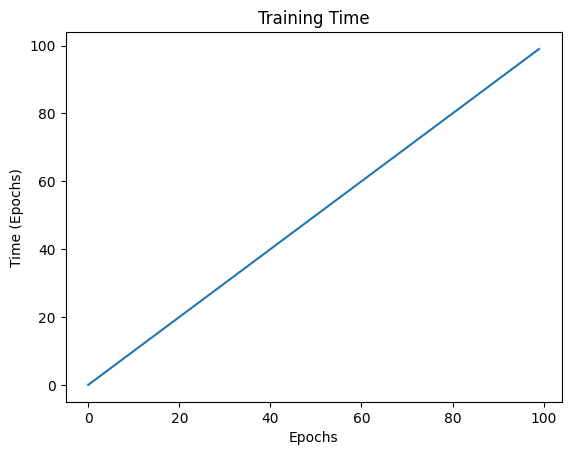

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve

# Plot Training and Validation Time
training_time = history.epoch
plt.plot(training_time, label='Training Time')
plt.title('Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (Epochs)')
plt.show()

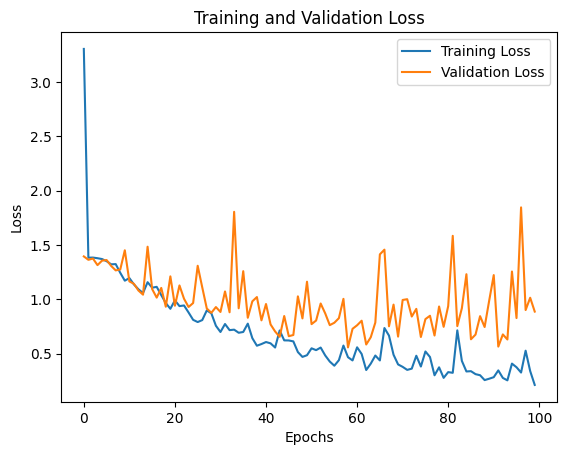

In [16]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

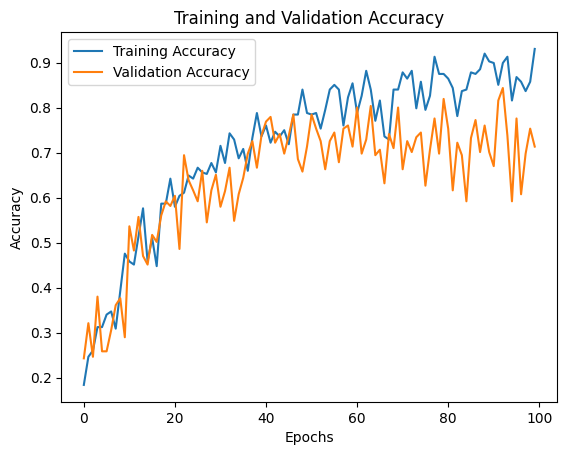

In [17]:
# Plot Training and Validation Accuracy
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, num_classes):
    plt.figure(figsize=(8, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


4/4 [==============================] - 5s 1s/step


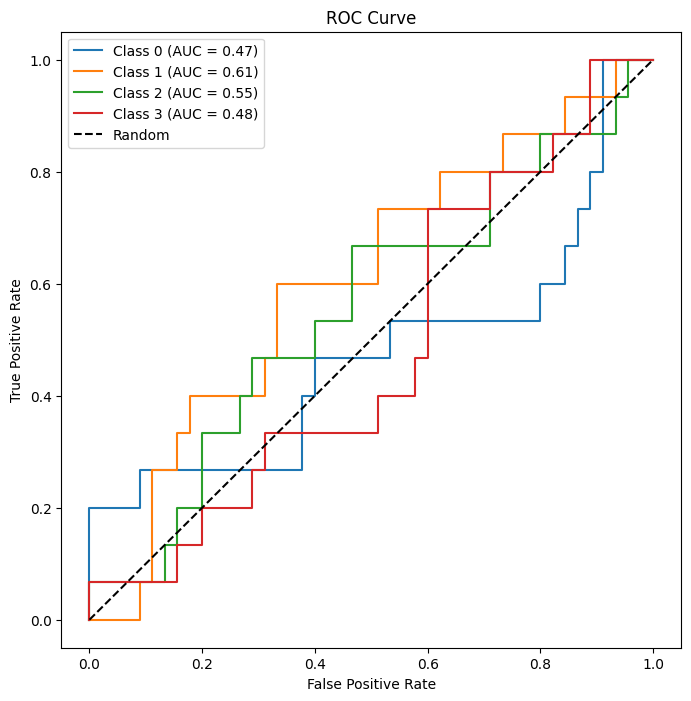

In [20]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = combined_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

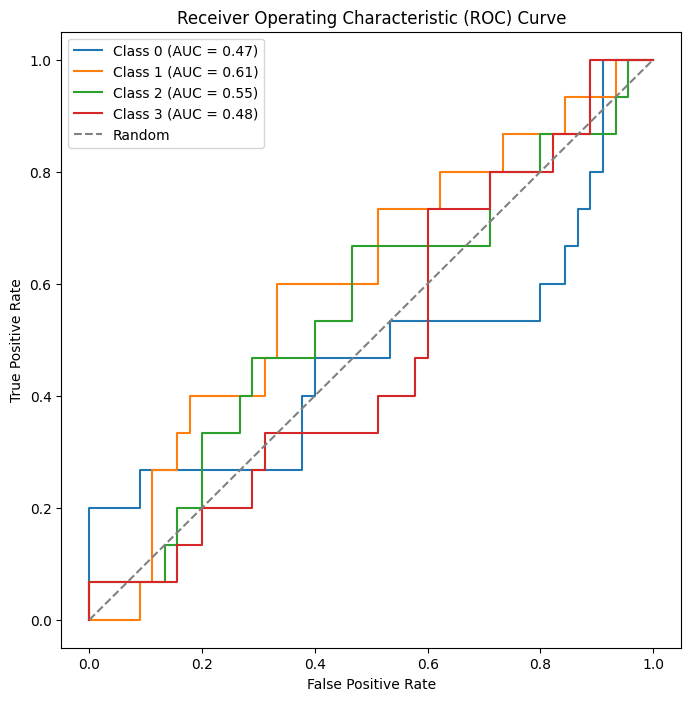

In [21]:
def plot_roc_curve(y_true, y_pred_prob, num_classes):
    plt.figure(figsize=(8, 8))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [23]:
# Evaluate the model on the test set
test_generator.reset()
y_prob = combined_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_prob, axis=1)

4/4 [==============================] - 5s 1s/step


Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        15
           1       0.12      0.13      0.13        15
           2       0.10      0.07      0.08        15
           3       0.29      0.33      0.31        15

    accuracy                           0.22        60
   macro avg       0.20      0.22      0.21        60
weighted avg       0.20      0.22      0.21        60


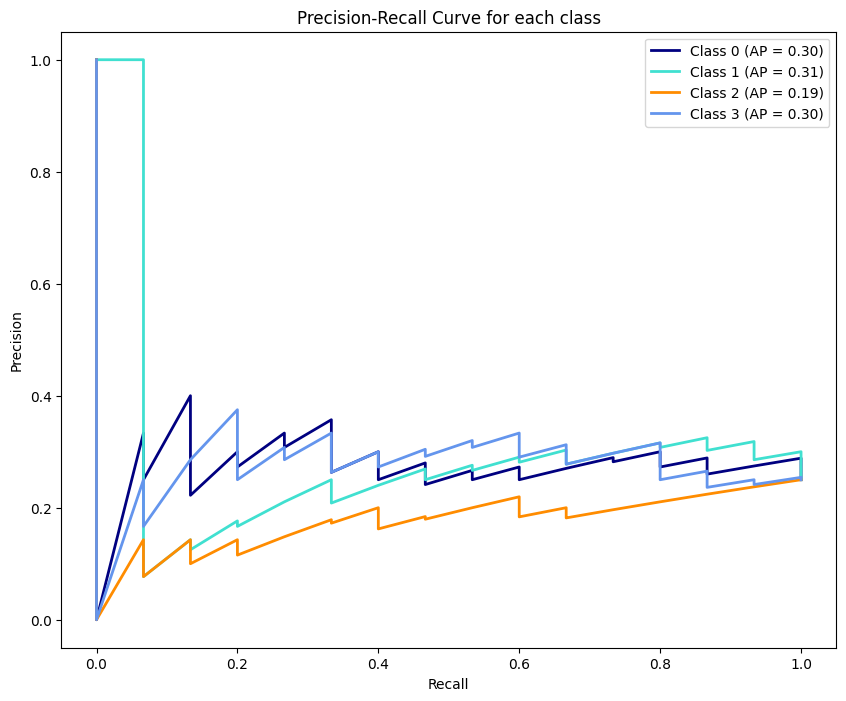

In [25]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 909ms/step - loss: 0.2141 - custom_accuracy: 0.9306
Test Accuracy: 0.9305555820465088
Test loss: 0.21413838863372803


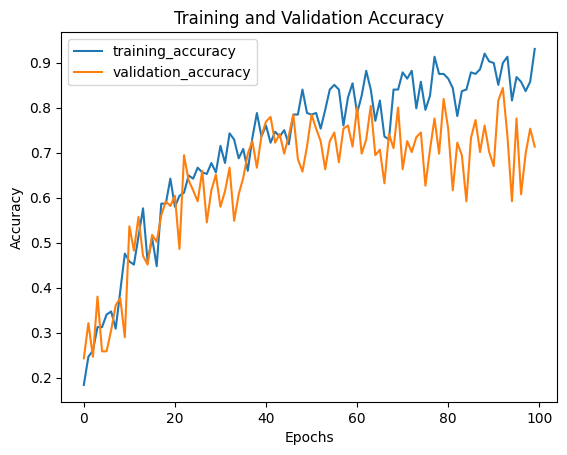

In [27]:
plt.plot(history.history['custom_accuracy'], label='training_accuracy')
plt.plot(history.history['val_custom_accuracy'], label='validation_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

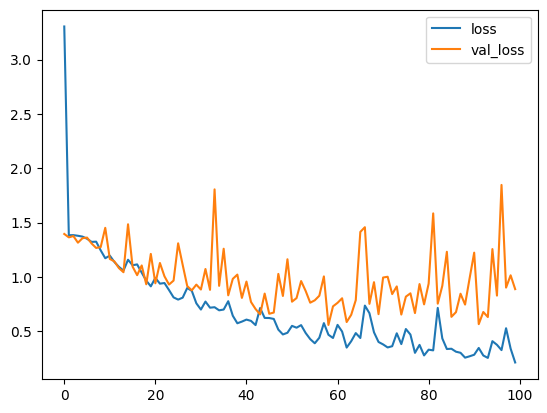

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# combined_model.save("model90.h5")